<a href="https://colab.research.google.com/github/Rosefinch-Midsummer/Awesome-Colab/blob/master/fastai/07_batchnorm%2Blsuv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
!git clone https://github.com/fastai/course-v3

In [3]:
cd course-v3/nbs/dl2

/content/course-v3/nbs/dl2


In [0]:
#export
from exp.nb_06 import *

## ConvNet

Let's get the data and training interface from where we left in the last notebook.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=5899)

In [5]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [9]:
%time run.fit(2, learn)

train: [1.54061578125, tensor(0.4754, device='cuda:0')]
valid: [0.374801123046875, tensor(0.8847, device='cuda:0')]
train: [0.22092578125, tensor(0.9342, device='cuda:0')]
valid: [0.14276248779296874, tensor(0.9572, device='cuda:0')]
CPU times: user 4.14 s, sys: 1.13 s, total: 5.27 s
Wall time: 11.2 s


## Batchnorm

### Custom

Let's start by building our own `BatchNorm` layer from scratch.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6018)

In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.28439931640625, tensor(0.9098, device='cuda:0')]
valid: [0.1267755859375, tensor(0.9618, device='cuda:0')]


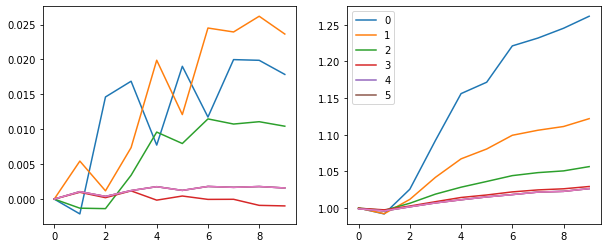

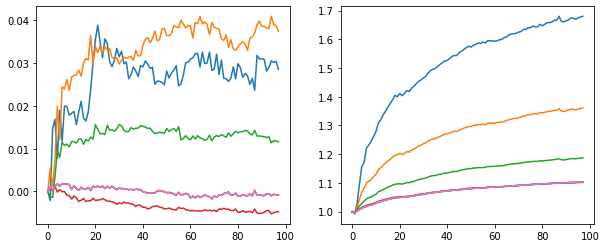

In [14]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [16]:
%time run.fit(3, learn)

train: [0.2683153515625, tensor(0.9150, device='cuda:0')]
valid: [0.11495645751953125, tensor(0.9668, device='cuda:0')]
train: [0.08236111328125, tensor(0.9751, device='cuda:0')]
valid: [0.1501632080078125, tensor(0.9510, device='cuda:0')]
train: [0.0604461181640625, tensor(0.9815, device='cuda:0')]
valid: [0.07413959350585937, tensor(0.9781, device='cuda:0')]
CPU times: user 3 s, sys: 373 ms, total: 3.37 s
Wall time: 3.35 s


### Builtin batchnorm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6679)

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [19]:
%time run.fit(3, learn)

train: [0.216511171875, tensor(0.9324, device='cuda:0')]
valid: [0.08217789916992188, tensor(0.9758, device='cuda:0')]
train: [0.062379228515625, tensor(0.9807, device='cuda:0')]
valid: [0.06469453735351563, tensor(0.9802, device='cuda:0')]
train: [0.04240828125, tensor(0.9870, device='cuda:0')]
valid: [0.06012373657226563, tensor(0.9820, device='cuda:0')]
CPU times: user 2.88 s, sys: 365 ms, total: 3.25 s
Wall time: 3.23 s


### With scheduler

Now let's add the usual warm-up/annealing.

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)]) 

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [22]:
run.fit(8, learn)

train: [0.25468876953125, tensor(0.9220, device='cuda:0')]
valid: [0.2212282470703125, tensor(0.9298, device='cuda:0')]
train: [0.08443138671875, tensor(0.9735, device='cuda:0')]
valid: [0.0806427734375, tensor(0.9753, device='cuda:0')]
train: [0.0564021533203125, tensor(0.9820, device='cuda:0')]
valid: [0.05879434204101563, tensor(0.9833, device='cuda:0')]
train: [0.033332607421875, tensor(0.9890, device='cuda:0')]
valid: [0.0689575439453125, tensor(0.9811, device='cuda:0')]
train: [0.020893935546875, tensor(0.9939, device='cuda:0')]
valid: [0.04840125732421875, tensor(0.9868, device='cuda:0')]
train: [0.012028076171875, tensor(0.9969, device='cuda:0')]
valid: [0.04455964050292969, tensor(0.9874, device='cuda:0')]
train: [0.0072020751953125, tensor(0.9985, device='cuda:0')]
valid: [0.042341143798828126, tensor(0.9876, device='cuda:0')]
train: [0.004905939331054688, tensor(0.9992, device='cuda:0')]
valid: [0.041592825317382814, tensor(0.9882, device='cuda:0')]


## More norms

### Layer norm

From [the paper](https://arxiv.org/abs/1607.06450): "*batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small*".

General equation for a norm layer with learnable affine:

$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is
1. we don't keep a moving average
2. we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=6717)

In [0]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [26]:
%time run.fit(3, learn)

train: [nan, tensor(0.1141, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.51 s, sys: 388 ms, total: 3.9 s
Wall time: 3.87 s


*Thought experiment*: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?

### Instance norm

From [the paper](https://arxiv.org/abs/1607.08022): 

The key difference between **contrast** and batch normalization is that the latter applies the normalization to a  whole batch of images instead for single ones:

\begin{equation}\label{eq:bnorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}},
    \quad
    \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2.
\end{equation}

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the *instance normalization* (also known as *contrast normalization*) layer:

\begin{equation}\label{eq:inorm}
    y_{tijk} =  \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}},
    \quad
    \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm},
    \quad
    \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2.
\end{equation}

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7114)

In [0]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [30]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 3.61 s, sys: 411 ms, total: 4.02 s
Wall time: 4 s


*Question*: why can't this classify anything?

Lost in all those norms? The authors from the [group norm paper](https://arxiv.org/pdf/1803.08494.pdf) have you covered:

![Various norms](https://github.com/fastai/course-v3/blob/master/nbs/dl2/images/norms.png?raw=1)

### Group norm

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7213)

*From the PyTorch docs:*

`GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)`

The input channels are separated into `num_groups` groups, each containing
``num_channels / num_groups`` channels. The mean and standard-deviation are calculated
separately over the each group. $\gamma$ and $\beta$ are learnable
per-channel affine transform parameter vectorss of size `num_channels` if
`affine` is ``True``.

This layer uses statistics computed from input data in both training and
evaluation modes.

Args:
-    num_groups (int): number of groups to separate the channels into
-    num_channels (int): number of channels expected in input
-    eps: a value added to the denominator for numerical stability. Default: 1e-5
-    affine: a boolean value that when set to ``True``, this module
        has learnable per-channel affine parameters initialized to ones (for weights)
        and zeros (for biases). Default: ``True``.

Shape:
- Input: `(N, num_channels, *)`
- Output: `(N, num_channels, *)` (same shape as input)

Examples::

    >>> input = torch.randn(20, 6, 10, 10)
    >>> # Separate 6 channels into 3 groups
    >>> m = nn.GroupNorm(3, 6)
    >>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
    >>> m = nn.GroupNorm(6, 6)
    >>> # Put all 6 channels into a single group (equivalent with LayerNorm)
    >>> m = nn.GroupNorm(1, 6)
    >>> # Activating the module
    >>> output = m(input)

## Fix small batch sizes

### What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7304)

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [34]:
%time run.fit(1, learn)

train: [2.2824771875, tensor(0.2106, device='cuda:0')]
valid: [8582311863.9104, tensor(0.1238, device='cuda:0')]
CPU times: user 1min 14s, sys: 1.25 s, total: 1min 15s
Wall time: 1min 16s


### Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=7516)

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [38]:
%time run.fit(1, learn)

train: [0.3791311328125, tensor(0.9017, device='cuda:0')]
valid: [0.1332256591796875, tensor(0.9739, device='cuda:0')]
CPU times: user 3min 9s, sys: 2.47 s, total: 3min 11s
Wall time: 3min 12s


This solves the small batch size issue!

### What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.

[Jump_to lesson 10 video](https://course.fast.ai/videos/?lesson=10&t=8068)

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [41]:
%time run.fit(1, learn)

train: [0.15600373046875, tensor(0.9506, device='cuda:0')]
valid: [0.07289594116210937, tensor(0.9791, device='cuda:0')]
CPU times: user 12.4 s, sys: 173 ms, total: 12.6 s
Wall time: 12.7 s


## Export

In [42]:
nb_auto_export()

<IPython.core.display.Javascript object>

# lsuv

In [43]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

#export
from exp.nb_07 import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Layerwise Sequential Unit Variance (LSUV)

Getting the MNIST data and a CNN

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

mnist_view = view_tfm(1,28,28)
cbfs = [Recorder,
        partial(AvgStatsCallback,accuracy),
        CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

class ConvLayer(nn.Module):
    def __init__(self, ni, nf, ks=3, stride=2, sub=0., **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True)
        self.relu = GeneralRelu(sub=sub, **kwargs)
    
    def forward(self, x): return self.relu(self.conv(x))
    
    @property
    def bias(self): return -self.relu.sub
    @bias.setter
    def bias(self,v): self.relu.sub = -v
    @property
    def weight(self): return self.conv.weight

learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

Now we're going to look at the paper [All You Need is a Good Init](https://arxiv.org/pdf/1511.06422.pdf), which introduces Layer-wise Sequential Unit-Variance (LSUV). We initialize our neural net with the usual technique, then we pass a batch through the model and check the outputs of the linear and convolutional layers. We can then rescale the weights according to the actual variance we observe on the activations, and subtract the mean we observe from the initial bias. That way we will have activations that stay normalized.

We repeat this process until we are satisfied with the mean/variance we observe.

Let's start by looking at a baseline:

In [46]:
run.fit(2, learn)

train: [2.106005, tensor(0.2683, device='cuda:0')]
valid: [0.92323720703125, tensor(0.6495, device='cuda:0')]
train: [0.4642139453125, tensor(0.8429, device='cuda:0')]
valid: [0.3443484619140625, tensor(0.8968, device='cuda:0')]


Now we recreate our model and we'll try again with LSUV. Hopefully, we'll get better results!

In [0]:
learn,run = get_learn_run(nfs, data, 0.6, ConvLayer, cbs=cbfs)

Helper function to get one batch of a given dataloader, with the callbacks called to preprocess it.

In [0]:
#export
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

xb,yb = get_batch(data.train_dl, run)

We only want the outputs of convolutional or linear layers. To find them, we need a recursive function. We can use sum(list, []) to concatenate the lists the function finds (sum applies the + operate between the elements of the list you pass it, beginning with the initial state in the second argument).

In [49]:
#export
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

def is_lin_layer(l):
    lin_layers = (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear, nn.ReLU)
    return isinstance(l, lin_layers)

mods = find_modules(learn.model, lambda o: isinstance(o,ConvLayer))

mods

[ConvLayer(
   (conv): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 ), ConvLayer(
   (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (relu): GeneralRelu()
 )]

This is a helper function to grab the mean and std of the output of a hooked layer.

In [0]:
def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.cuda()

So now we can look at the mean and std of the conv layers of our model.

In [52]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

0.37947285175323486 0.8837525844573975
0.247650146484375 0.7131402492523193
0.2943534255027771 0.618182361125946
0.3359931409358978 0.5304023027420044
0.18318921327590942 0.28497058153152466


We first adjust the bias terms to make the means 0, then we adjust the standard deviations to make the stds 1 (with a threshold of 1e-3). The mdl(xb) is not None clause is just there to pass xb through mdl and compute all the activations so that the hooks get updated.

In [0]:
#export
def lsuv_module(m, xb):
    h = Hook(m, append_stat)

    while mdl(xb) is not None and abs(h.mean)  > 1e-3: m.bias -= h.mean
    while mdl(xb) is not None and abs(h.std-1) > 1e-3: m.weight.data /= h.std

    h.remove()
    return h.mean,h.std

We execute that initialization on all the conv layers in order:

In [54]:
for m in mods: print(lsuv_module(m, xb))

(0.04991528019309044, 1.0)
(0.12461666017770767, 0.9999999403953552)
(0.10516810417175293, 0.9999998807907104)
(0.14159101247787476, 0.9999999403953552)
(0.3418874144554138, 1.0)


Note that the mean doesn't exactly stay at 0. since we change the standard deviation after by scaling the weight.

Then training is beginning on better grounds.

In [55]:
%time run.fit(2, learn)

train: [0.509484765625, tensor(0.8343, device='cuda:0')]
valid: [0.131029345703125, tensor(0.9597, device='cuda:0')]
train: [0.105779970703125, tensor(0.9683, device='cuda:0')]
valid: [0.09691842041015625, tensor(0.9714, device='cuda:0')]
CPU times: user 1.86 s, sys: 343 ms, total: 2.2 s
Wall time: 2.19 s


LSUV is particularly useful for more complex and deeper architectures that are hard to initialize to get unit variance at the last layer.

## Export

In [0]:
#!python notebook2script.py 07a_lsuv.ipynb